In [2]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub as k
from kagglehub import KaggleDatasetAdapter


ModuleNotFoundError: No module named 'tensorflow'

# Load HAM10000 metadata

In [ ]:

df = k.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "kmader/skin-cancer-mnist-ham10000",
    "HAM10000_metadata.csv"
)
print(df.head())


/tmp/ipython-input-1946628206.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = k.load_dataset(


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


# Map images to labels (benign=0, malignant=1)

In [ ]:

benign = ["nv", "bkl", "df", "vasc"]   # benign classes
df["binary_label"] = df["dx"].apply(lambda x: 0 if x in benign else 1)

# Path to image folder (auto downloaded by kagglehub inside ~/.cache)
dataset_path = k.dataset_download("kmader/skin-cancer-mnist-ham10000")

# Load images as arrays

In [ ]:

def load_image(img_id, label):
    img_path_part1 = os.path.join(dataset_path, "HAM10000_images_part_1", f"{img_id}.jpg")
    img_path_part2 = os.path.join(dataset_path, "HAM10000_images_part_2", f"{img_id}.jpg")

    if os.path.exists(img_path_part1):
        img_path = img_path_part1
    elif os.path.exists(img_path_part2):
        img_path = img_path_part2
    else:
        raise FileNotFoundError(f"Image file not found for {img_id}")

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128,128))
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img, label

X, y = zip(*[load_image(row["image_id"], row["binary_label"]) for _, row in df.iterrows()])
X, y = np.array(X), np.array(y)


# Train-test split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



Build CNN model

In [ ]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train model

In [ ]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)



Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7854 - loss: 0.5908 - val_accuracy: 0.8048 - val_loss: 0.4461
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8029 - loss: 0.4223 - val_accuracy: 0.8048 - val_loss: 0.4503
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8251 - loss: 0.3806 - val_accuracy: 0.8048 - val_loss: 0.4191
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8203 - loss: 0.3820 - val_accuracy: 0.8248 - val_loss: 0.3730
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8295 - loss: 0.3689 - val_accuracy: 0.8238 - val_loss: 0.3748


# Evaluate

In [ ]:

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.2f}")



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8321 - loss: 0.3585
✅ Test Accuracy: 0.82


# Plot accuracy

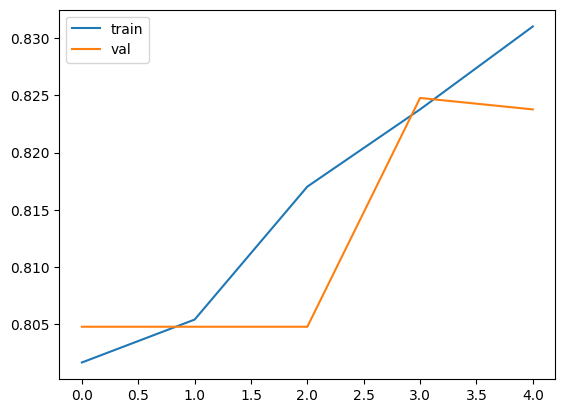

In [ ]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()